In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore, t

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor


from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
columns = ['mpg','cylinders','displacement','horsepower','weight','acceleration','year','origin','name']
df = pd.read_csv(uploaded,delim_whitespace=True,names=columns)

#drop name column
df.drop(columns=['name'],inplace=True)

columns = ['cylinders','displacement','horsepower','weight','acceleration','year','origin']
print(df.shape)
df.dtypes

(398, 8)


mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
year              int64
origin            int64
dtype: object

In [3]:
df.horsepower.unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

In [4]:
df=df[df['horsepower']!='?']
df['horsepower']=df['horsepower'].astype('float')
df.isnull().any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
year            False
origin          False
dtype: bool

In [5]:
df[columns]=StandardScaler().fit_transform(df[columns])

#apply z-score outlier treatment
z = np.abs(zscore(df))
df = df[(z < 3).all(axis=1)]

print(df.shape)
df.head()

(385, 8)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,1.483947,1.077290,0.664133,0.620540,-1.285258,-1.625315,-0.716641
1,15.0,1.483947,1.488732,1.574594,0.843334,-1.466724,-1.625315,-0.716641
2,18.0,1.483947,1.182542,1.184397,0.540382,-1.648189,-1.625315,-0.716641
3,16.0,1.483947,1.048584,1.184397,0.536845,-1.285258,-1.625315,-0.716641
4,17.0,1.483947,1.029447,0.924265,0.555706,-1.829655,-1.625315,-0.716641


In [6]:
X_orig=df[columns]
y=df['mpg']
print(X_orig.shape)
pd.DataFrame(data=[X_orig.skew(),X_orig.kurtosis()],index=['skewness','kurtosis'])

(385, 7)


,cylinders,displacement,horsepower,weight,acceleration,year,origin
skewness,0.533598,0.672639,0.971972,0.531125,0.227886,0.012683,0.902325
kurtosis,-1.357577,-0.870397,0.326162,-0.783535,0.184673,-1.158124,-0.873909


In [7]:
outliers = LocalOutlierFactor(n_neighbors=20).fit_predict(X_orig)
target_out = LocalOutlierFactor(n_neighbors=20).fit_predict(y.values.reshape(-1,1))

outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X_orig,y=X_orig[outliers],y[outliers]
X_orig.shape

(366, 7)

In [8]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_orig.values, i) for i in range(X_orig.shape[1])]
vif["features"] = pd.Index(X_orig.columns)
vif

,VIF Factor,features
0,11.612756,cylinders
1,25.224016,displacement
2,12.045105,horsepower
3,13.650862,weight
4,2.948990,acceleration
5,1.178280,year
6,1.780656,origin


In [9]:
# Highest VIF>= 10 value is for displacement(25.1), remove displacement
# 'cylinders','displacement','horsepower','weight','acceleration','year','origin'
X = X_orig
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = pd.Index(X.columns)
vif

,VIF Factor,features
0,11.612756,cylinders
1,25.224016,displacement
2,12.045105,horsepower
3,13.650862,weight
4,2.948990,acceleration
5,1.178280,year
6,1.780656,origin


In [10]:
# Highest VIF>=10 value is for horsepower(VIF=11.6), remove horsepower
# 'cylinders','displacement','horsepower','weight','acceleration','year','origin'
X = X.drop(['displacement'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = pd.Index(X.columns)
vif

,VIF Factor,features
0,6.068045,cylinders
1,11.629223,horsepower
2,10.803007,weight
3,2.913342,acceleration
4,1.164594,year
5,1.582154,origin


In [11]:
# Highest VIF>=10 value is for horsepower(VIF=11.6), remove horsepower
# 'cylinders','displacement','horsepower','weight','acceleration','year','origin'
X = X.drop(['horsepower'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = pd.Index(X.columns)
vif

,VIF Factor,features
0,5.985752,cylinders
1,5.380115,weight
2,1.381748,acceleration
3,1.106418,year
4,1.523176,origin


In [12]:
k=X.shape[1]
acc_metric = 'neg_mean_squared_error'
# acc_metric = 'neg_mean_absolute_error'
cv = KFold(n_splits=10, shuffle= True,random_state=100)
model_selected=None
minRMSE=np.inf
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])

try:
    X=X.to_numpy()
except:
    pass
try:
    y=y.to_numpy()
except:
    pass
X.shape

(366, 5)

In [13]:
# Dimash's version
# def get_soc(final_clf, features):
#     soc = 0
#     n = 7     # for tanh
#     if( final_clf.get_params()['activation'] == 'relu' ):
#       n = 1
#     elif ( final_clf.get_params()['activation'] == 'logistic' ):
#       n = 3

#     for i in final_clf.get_params()['hidden_layer_sizes']:
#       soc += ( 2 * features + n * i )
#       features = i
#     soc += 2 * features * final_clf.n_outputs_
#     return soc

In [14]:
# Prof's version
def get_soc(clf, P):
    soc=0
    ac=clf.get_params()['activation']
    At = (ac=='relu')*1 + (ac=='logistic')*4 + (ac=='tanh') * 9
    N = list(clf.get_params()['hidden_layer_sizes'])
    N.insert(0,P)
    H = len(N)
    N.append(clf.n_outputs_)
    
    for h in range(H):
        soc += (2 * N[h] + At) * N[h+1] + 2*N[h+1]
    return soc

In [15]:
arr_mse = []
arr_mae = []
arr_soc = []
arr_hls = []

In [18]:
# My Experimental block

# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_3 = {
 'activation': ['relu'], 
 'hidden_layer_sizes': [(50,50)], 
 'learning_rate_init': [0.000774263682681127]
}
res = []

for _ in range(1): 
    clf = MLPRegressor()
    grid = GridSearchCV(clf, param_grid = params_3, cv=5, scoring='neg_mean_absolute_error')
    grid.fit(X, y)

#     print("Best Hyperparameters::\n{}".format(grid.best_params_))
#     results = pd.DataFrame(data=grid.cv_results_)

    final_clf = grid.best_estimator_

#     _,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

#     plt.title("Learning curve")
#     plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
#     plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
#     plt.legend()
#     plt.xlabel('train size')
#     plt.ylabel('MSE')
#     plt.show()

#     mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
    mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

#     std = np.std(mse)
#     mse = np.abs(np.mean(mse))
    mae = np.abs(np.mean(mae))

    soc=get_soc(final_clf, 5)

#     arr_mse.append(mse)
    arr_mae.append(mae)
    arr_soc.append(soc)
    arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

#     print("mse : ", mse)
    print("mae : ", mae)
    print("soc : ", soc)
    res.append(mae)
print(res)

mae :  2.5107868345773996
soc :  5903
[2.5107868345773996]


In [19]:
sum(res)/len(res)

2.5107868345773996

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}


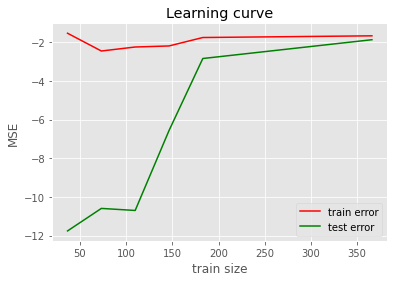

mse :  7.23807808108366
mae :  1.9399038456049715
soc :  1503


In [49]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_1 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(100,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_1, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (150, 150, 150, 150), 'learning_rate_init': 0.0002782559402207126}


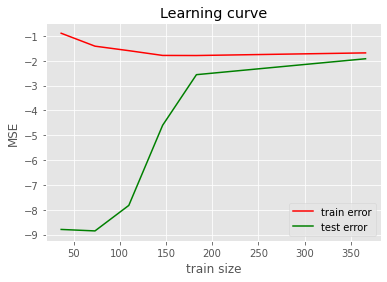

mse :  7.380522236047403
mae :  1.9809110766362892
soc :  138603


In [21]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_2 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(50, 50, 50, 50), (100, 100, 100, 100), (150, 150, 150, 150)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_2, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50, 50), 'learning_rate_init': 0.003593813663804626}


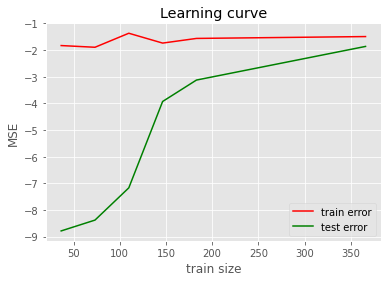

mse :  6.825970570666965
mae :  1.9804632392803825
soc :  16203


In [22]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_3 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(25,25,25,25), (50,50,50,50), (75,75,75,75)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_3, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (75, 75, 75, 75), 'learning_rate_init': 0.000774263682681127}


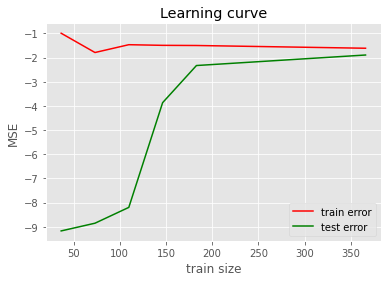

mse :  6.626403034106997
mae :  1.9236399518015062
soc :  35553


In [23]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_4 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(65,65,65,65), (85,85,85,85), (75,75,75,75)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_4, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (85, 85, 85, 85), 'learning_rate_init': 0.000774263682681127}


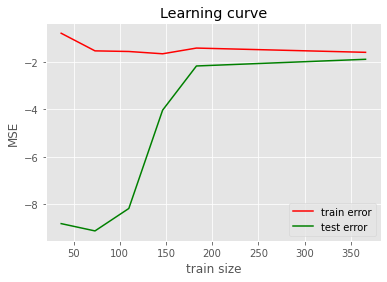

mse :  6.868666316285115
mae :  1.8904334106222649
soc :  45393


In [24]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_5 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(80,80,80,80), (85,85,85,85), (70,70,70,70), (90,90,90,90)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_5, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (73, 73, 73, 73), 'learning_rate_init': 0.000774263682681127}


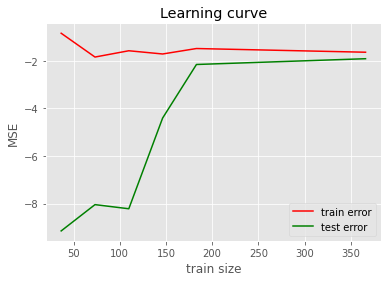

mse :  6.950667266911242
mae :  1.9173802042231305
soc :  33729


In [44]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_6 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(73,73,73,73), (77,77,77,7), (70,70,70,70)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_6, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate_init': 0.000774263682681127}


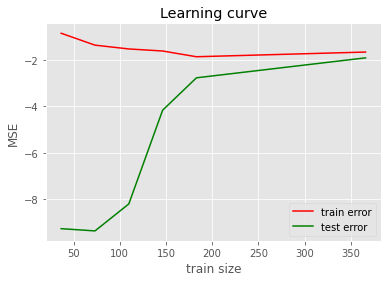

mse :  6.839354334969771
mae :  1.9539998349206773
soc :  42103


In [26]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(100,100,100), (50,50,50,50), (50,50,50)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.003593813663804626}


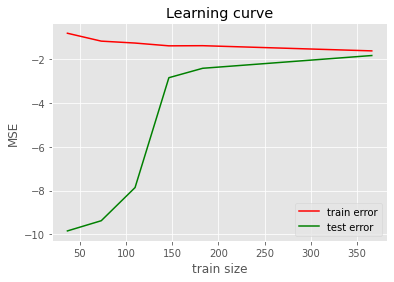

mse :  7.036716480406821
mae :  1.9545468749213597
soc :  21803


In [27]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(100,100),(50,50,50)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'learning_rate_init': 0.01}


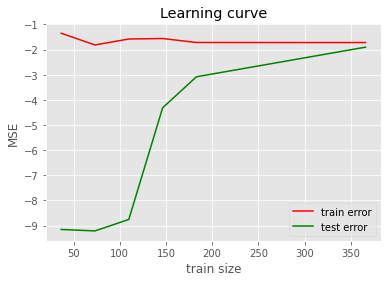

mse :  7.307908694792377
mae :  1.9965984481112122
soc :  613


In [28]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(50,50),(100,), (10,10,10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}


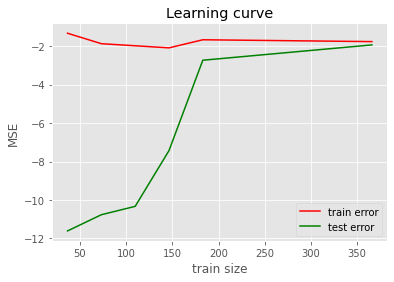

mse :  7.80853077721877
mae :  2.0324618286034553
soc :  753


In [29]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(50,),(10,), (10,10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.01}


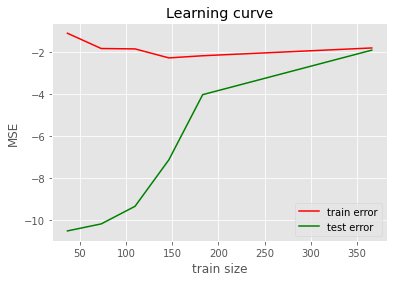

mse :  7.6233027656817285
mae :  2.083152221232987
soc :  383


In [30]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(20,),(10,), (10,10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (20, 20), 'learning_rate_init': 0.01}


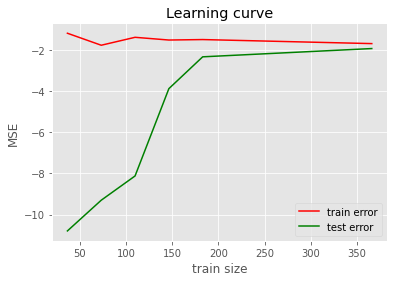

mse :  6.9605641737749036
mae :  1.938347668052383
soc :  1163


In [31]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(20,20),(10,),(25,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (15, 15), 'learning_rate_init': 0.005994842503189409}


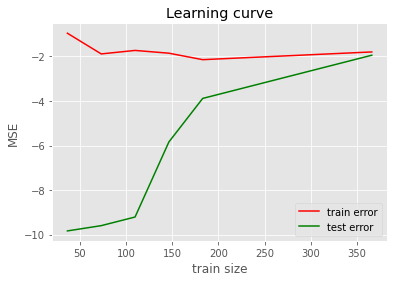

mse :  7.908959219823657
mae :  2.012236409042604
soc :  723


In [32]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(15,15),(25,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (12, 12), 'learning_rate_init': 0.01}


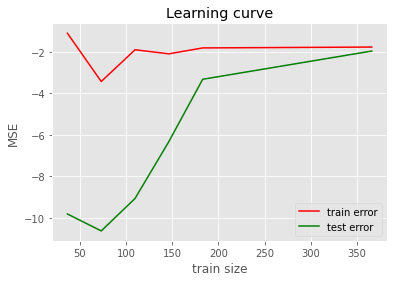

mse :  7.767121685474898
mae :  2.0924571766085096
soc :  507


In [33]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(12,12),(20,),(5,5,5)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (11, 11), 'learning_rate_init': 0.005994842503189409}


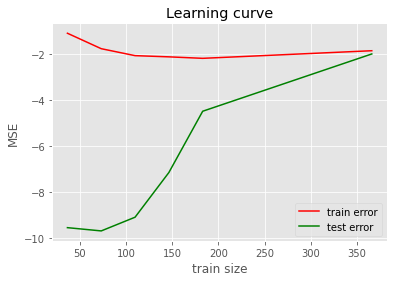

(11, 11)
mse :  8.714544316436323
mae :  2.0688444684247886
soc :  443


In [36]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(11,11),(21,),(22),(7,7,7)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

print(final_clf.get_params()['hidden_layer_sizes'])
soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.01}


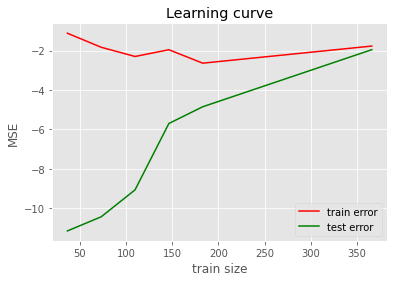

mse :  7.9977486260572
mae :  1.968866660970654
soc :  383


In [37]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(10,10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (5, 5), 'learning_rate_init': 0.01}


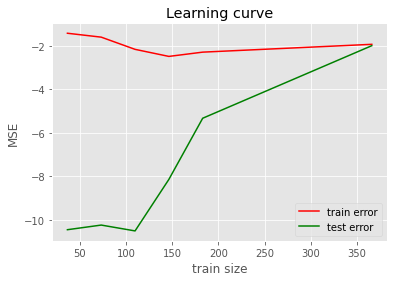

(5, 5)
mse :  8.905287054343109
mae :  2.2544347150639146
soc :  143


In [39]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(5,5),(10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
print(final_clf.get_params()['hidden_layer_sizes'])
soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (8, 8), 'learning_rate_init': 0.005994842503189409}


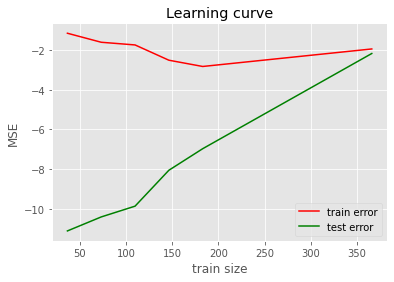

mse :  8.731034217754722
mae :  2.106147805941519
soc :  275


In [40]:


# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(7,7,),(8,8),(10)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (7, 7), 'learning_rate_init': 0.005994842503189409}


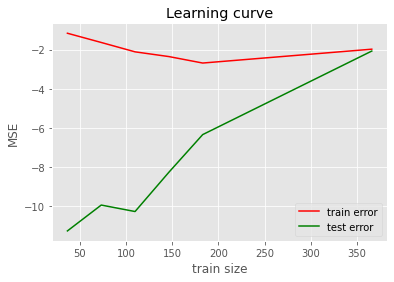

mse :  9.70957394763117
mae :  2.1801740560135876
soc :  227


In [41]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(7,7,),(15,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (6, 6), 'learning_rate_init': 0.01}


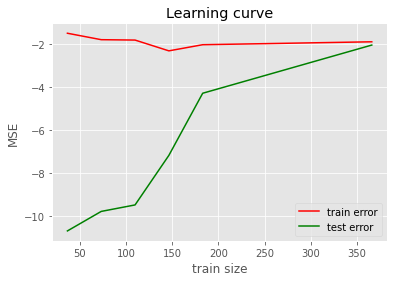

mse :  8.299240881607997
mae :  2.179865128168748
soc :  183


In [42]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(6,6,),(12,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (3, 3, 3), 'learning_rate_init': 0.002154434690031882}


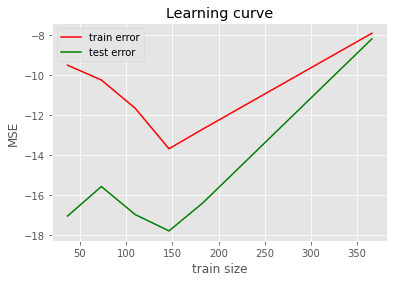

mse :  202.28640953620982
mae :  8.2698882095057
soc :  102


In [43]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(3,3,3), (2,2,2),(1,1,1,1),(2,2,2,2)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 5)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

X = SelectKBest(f_regression, k=4).fit_transform(X_orig, y)

In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(7,7)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 4)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

In [ ]:
X = SelectKBest(f_regression, k=3).fit_transform(X_orig, y)

Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (7, 7), 'learning_rate_init': 0.01}


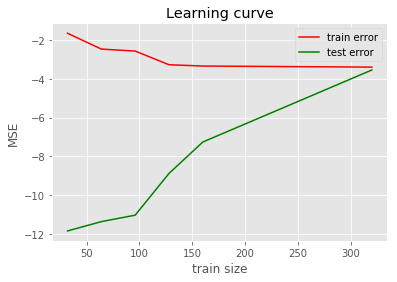

mse :  20.006972231464935
mae :  3.7040791205811425
soc :  48


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(7,7)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))

soc=get_soc(final_clf, 3)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])

print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

In [ ]:
arr_mae, arr_soc

([1.8501569403554512,
  1.7884720797170153,
  1.7737071811184777,
  1.8167754414118928,
  1.8883323455226688,
  1.8705487717763938,
  1.830370321723611,
  1.8357588080252978,
  1.8510252981339548,
  1.9100406552393767,
  1.9700491617414155,
  1.8671834288314155,
  1.914349637734422,
  1.933352355786728,
  1.8931515812263904,
  1.8716991054530627,
  2.0552448777105012,
  1.8981976315865565,
  1.906444019830706,
  1.9996059174279441,
  1.9200871098172825],
 [1210,
  610,
  910,
  1030,
  1090,
  850,
  610,
  460,
  310,
  160,
  70,
  130,
  100,
  82,
  76,
  70,
  40,
  58,
  52,
  46,
  50])

In [ ]:
arr_mae_min = [1.7737071811184777]
arr_soc_min = [910]
arr_mae_min_soc = [1.9200871098172825]
arr_soc_min_soc = [50]

In [ ]:
arr_mae_not_allowed = [ x for x in arr_mae if x >= arr_mae_min[0]*1.1 ]
arr_mae_not_allowed

[1.9700491617414155, 2.0552448777105012, 1.9996059174279441]

In [ ]:
arr_mae_not_allowed_soc = [70,40,46]

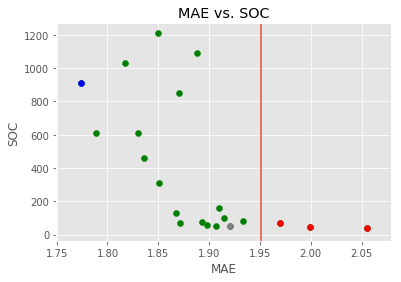

In [ ]:
plt.title("MAE vs. SOC")

plt.scatter(arr_mae, arr_soc, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, [50], c='grey')
plt.axvline(x=arr_mae_min[0]*1.1)
plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

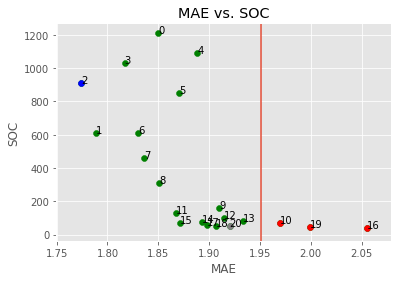

In [ ]:
plt.title("MAE vs. SOC")

plt.scatter(arr_mae, arr_soc, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, [50], c='grey')
plt.axvline(x=arr_mae_min[0]*1.1)

for i, txt in enumerate(arr_mae):
    plt.annotate(i, (arr_mae[i], arr_soc[i]))

plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

In [ ]:
data = { 'MAE': arr_mae, 'SOC': arr_soc, 'Hidden Layer Size ': arr_hls }
df = pd.DataFrame(data)
df

,MAE,SOC,Hidden Layer Size
0,1.850157,1210,"(100, 100, 100, 100)"
1,1.788472,610,"(50, 50, 50, 50)"
2,1.773707,910,"(75, 75, 75, 75)"
3,1.816775,1030,"(85, 85, 85, 85)"
4,1.888332,1090,"(90, 90, 90, 90)"
5,1.870549,850,"(70, 70, 70, 70)"
6,1.830370,610,"(50, 50, 50, 50)"
7,1.835759,460,"(50, 50, 50)"
8,1.851025,310,"(100,)"
9,1.910041,160,"(50,)"
